In [1]:
#Загружаем библиотеки
import numpy as np
import pandas as pd
import random
import pickle
import math


from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2, f1_score as f1, classification_report
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings

import os

Home Ownership                - Домоволадение

Annual Income                 - Годовой доход

Years in current job          - Годы на текущем месте работы

Tax Liens                     - Налоговые льготы

Number of Open Accounts       - Количество открытых счетов

Years of Credit History       - Годы кредитной истории

Maximum Open Credit           - Максимальный открытый кредит

Number of Credit Problems     - Количество кредитныйх проблем

Months since last delinquent  - Месяцы с последнего нарушения

Bankruptcies                  - Банкротство

Purpose                       - Цель

Term                          - Срок

Current Loan Amount           - Текущая сумма кредита

Current Credit Balance        - Текущий кредитный баланс

Monthly Debt                  - Ежемесячный долг

Credit Score                  - Кредитный рейтинг

Credit Default                - Кредитный дефолт

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [5]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [6]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [7]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [8]:


matplotlib.rcParams.update({'font.size':14})

#Создаем переменные и присваиваем им значения путей к тестовому и тренировочному файлу 
train_path = 'course_project_train.csv'
test_path =  'course_project_test.csv'

#Читаем файл с тестовыми данными
test_df = pd.read_csv(test_path)
test_df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [9]:
#Читаем файл с тренировочными данными
train_df = pd.read_csv(train_path)

train_df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [10]:
feature_names = test_df.columns.drop(['Home Ownership','Purpose','Term']).tolist()
target_name = 'Credit Default'
columns = test_df.columns.tolist()

train_df['ID'] = train_df.index.tolist()
test_df['ID'] = test_df.index.tolist()
columns

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [11]:
test_df.shape,train_df.shape

((2500, 17), (7500, 18))

In [12]:
train_df.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
ID                                               0
Name: 0, dtype: object

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

__Обработка пропусков__

In [14]:
"Тестовая выборка ",len(test_df) - test_df.count(), '',"Тренировочная выбока",len(train_df) - train_df.count()

('Тестовая выборка ',
 Home Ownership                     0
 Annual Income                    513
 Years in current job              86
 Tax Liens                          0
 Number of Open Accounts            0
 Years of Credit History            0
 Maximum Open Credit                0
 Number of Credit Problems          0
 Months since last delinquent    1358
 Bankruptcies                       3
 Purpose                            0
 Term                               0
 Current Loan Amount                0
 Current Credit Balance             0
 Monthly Debt                       0
 Credit Score                     513
 ID                                 0
 dtype: int64,
 '',
 'Тренировочная выбока',
 Home Ownership                     0
 Annual Income                   1557
 Years in current job             371
 Tax Liens                          0
 Number of Open Accounts            0
 Years of Credit History            0
 Maximum Open Credit                0
 Number of Credit Pro

### Выводим матрицу корреляции

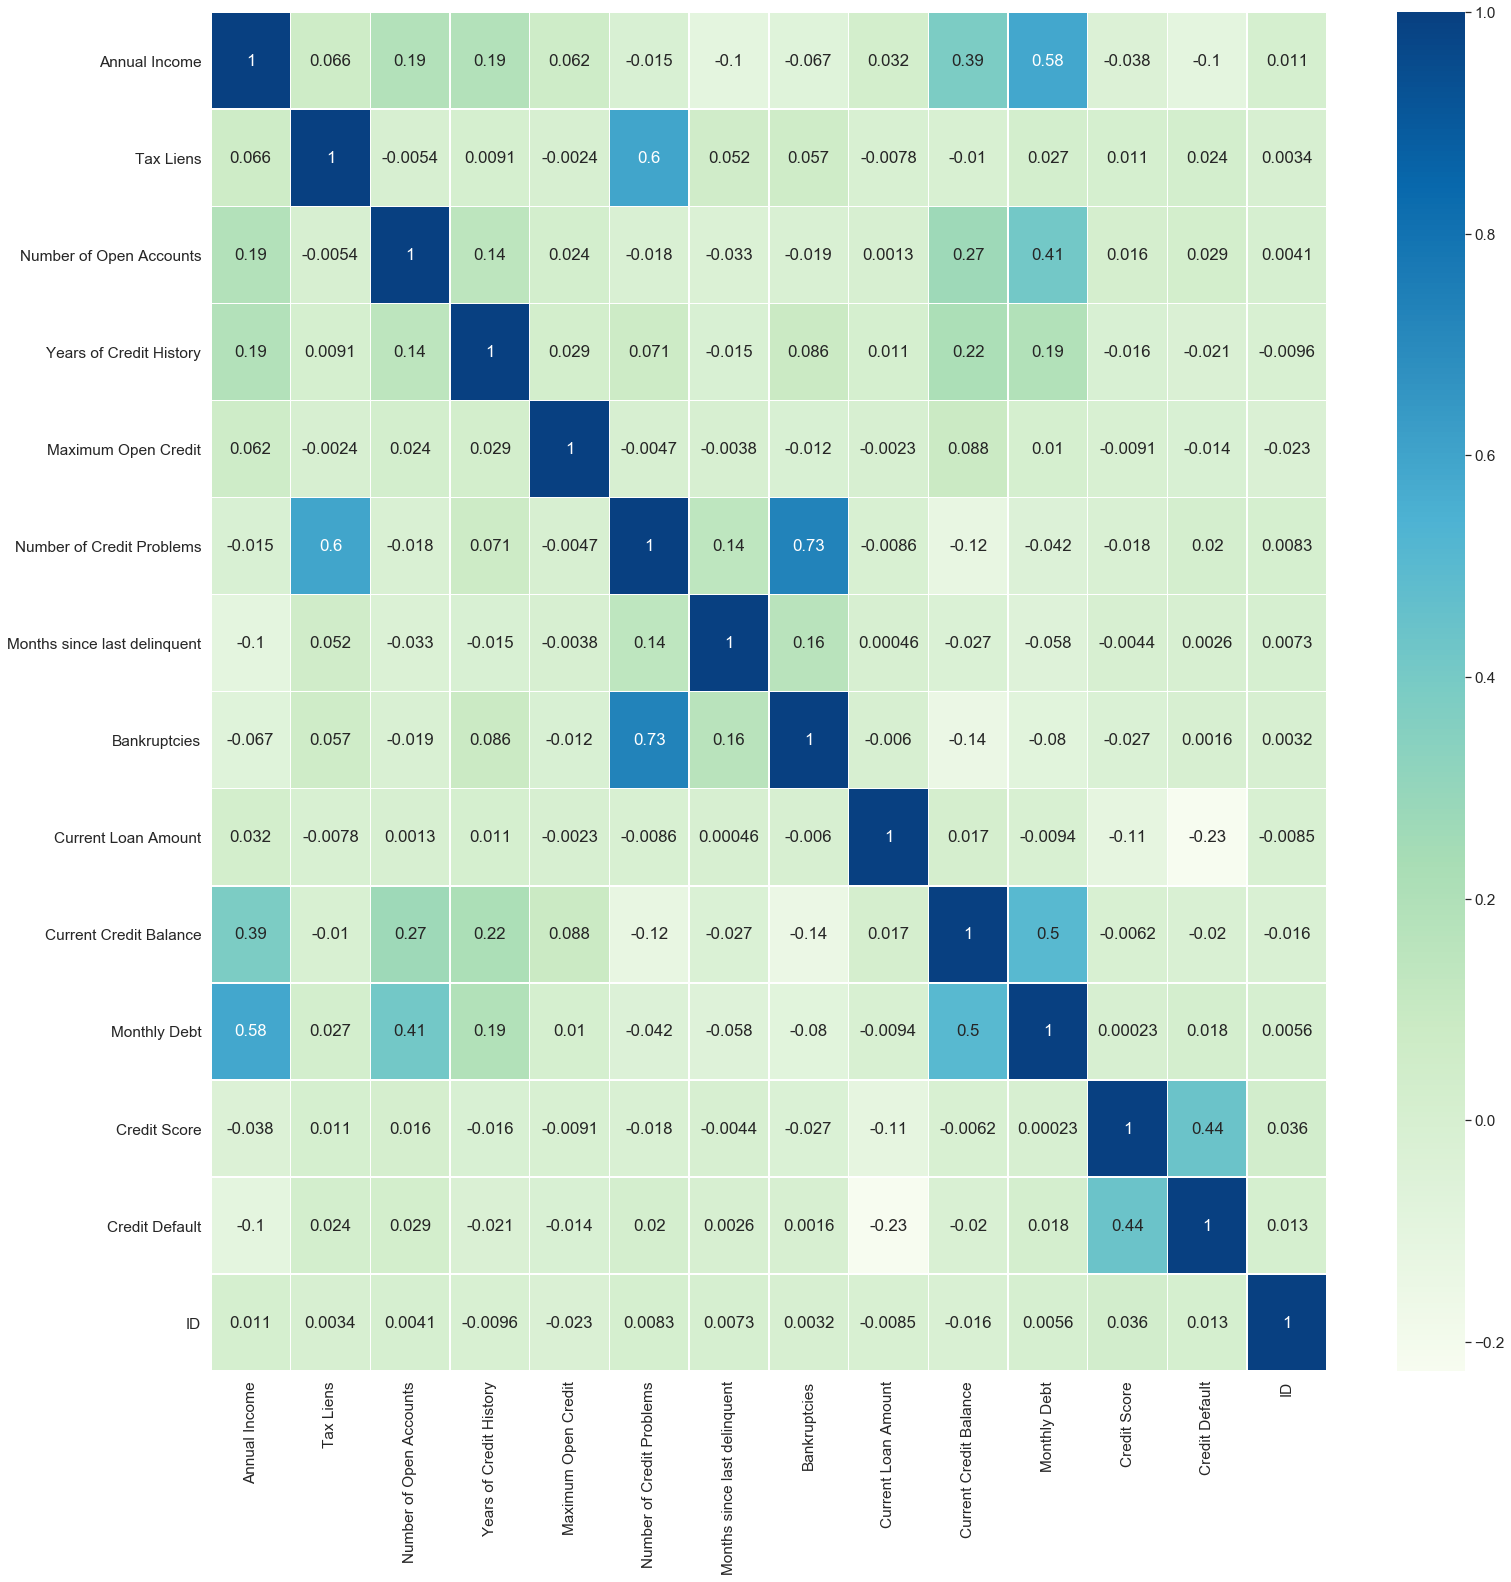

In [15]:

df_corr = train_df.corr()
plt.figure(figsize = (25,25))

sns.set(font_scale=1.4)
sns.heatmap(df_corr, annot=True, linewidths=.5, cmap='GnBu')

# plt.title('Correlation matrix')
plt.show()

In [16]:
# Процедура создает поле идентификатор для заданного категориального признака
def add_col_do_df(df, cols):
    def add_id_col(df, col):
        new_col = f'{col}_id'
        df[new_col]=0
        columns.append(new_col)
        for k, v in enumerate(df[col].unique()):
            df.loc[df[col]==v, new_col] = k+1 
            
    def col_to_categorial(df, col):
        df[col] = pd.Categorical(df[col])
    
    for k, col in enumerate(cols):
        add_id_col(df, col)
        col_to_categorial(df, col)

In [17]:
#Для категориальных признаков создадим идентификаторы
add_col_do_df(train_df, ['Home Ownership','Purpose','Term'])
add_col_do_df(test_df, ['Home Ownership','Purpose','Term'])

In [18]:
##Чистим года
def replace_str_to_int(df, arr, col ='Years in current job' , new_col = 'Years in current job'):
    new = {}
    for word in arr:
        if pd.isna(word) == True or type(word) in (np.float64, np.int):
            new['nan'] = 0
            df.loc[df[col].isna(), new_col] = 0
            continue
        i = ''
        for item in word:
            if ord(item) >=48 and ord(item) <=57:
                i = f'{i}{item}'
                new[word] = i
        
        df.loc[df[col]==word, new_col] = i
                
    df[col] = df[col].astype(float)
    
#     оставим массив для возможного мапинга со старыми значениями
    return new

In [19]:
##Чистим года
replace_str_to_int(train_df, train_df['Years in current job'].unique())
replace_str_to_int(test_df, test_df['Years in current job'].unique())

{'4 years': '4',
 '1 year': '1',
 '3 years': '3',
 '10+ years': '10',
 '6 years': '6',
 '5 years': '5',
 '< 1 year': '1',
 '2 years': '2',
 '9 years': '9',
 '8 years': '8',
 '7 years': '7',
 'nan': 0}

## Гипотиза:
- если человеку дали кредит , значит он работал.
Вычислим моду доли выданного кредита (месячный кредит * 12 месяцев / годовую зарплату)
Полученный процент используем для заполнения "Годовой доход"  = Ежемесячный Кредит * 12 (100-мода) / мода 
 и "Текущая сумма кредита"

In [20]:
tip_rate = train_df.loc[(train_df['Annual Income'].notna()) & (train_df['Current Loan Amount'] < 99999999.0)
             ].assign(tip_rate=train_df['Monthly Debt'] * 12 * 100 / train_df['Current Loan Amount']
                     )
tip_rate_df  = tip_rate.round(0)

mean = round(tip_rate_df['tip_rate'].mean(), 2)
median = tip_rate_df['tip_rate'].median()
mode = tip_rate_df['tip_rate'].mode()[0]

mean, median, mode

(93.02, 68.0, 53.0)

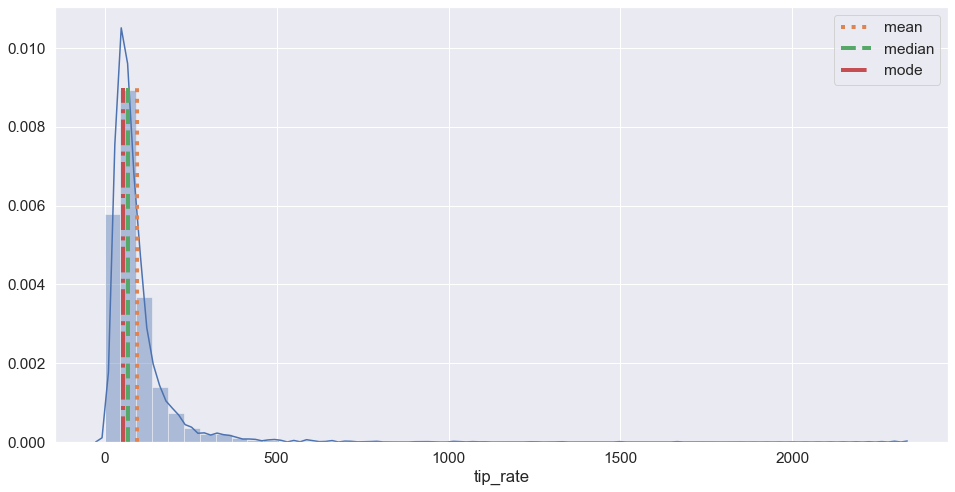

In [21]:
plt.figure(figsize = (16, 8))

sns.distplot(tip_rate_df['tip_rate'])

y = np.linspace(0, 0.009, 100)
plt.plot([mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

# plt.title('')
plt.legend()
plt.show()

In [22]:
## Выбросы немного подправим

In [23]:
tip_rate_df.loc[tip_rate_df['tip_rate']>200, ['tip_rate']
               ] = tip_rate_df['tip_rate'].mode()[0]

mean = round(tip_rate_df['tip_rate'].mean(), 2)
median = tip_rate_df['tip_rate'].median()
mode = tip_rate_df['tip_rate'].mode()[0]

mean, median, mode

(71.53, 61.0, 53.0)

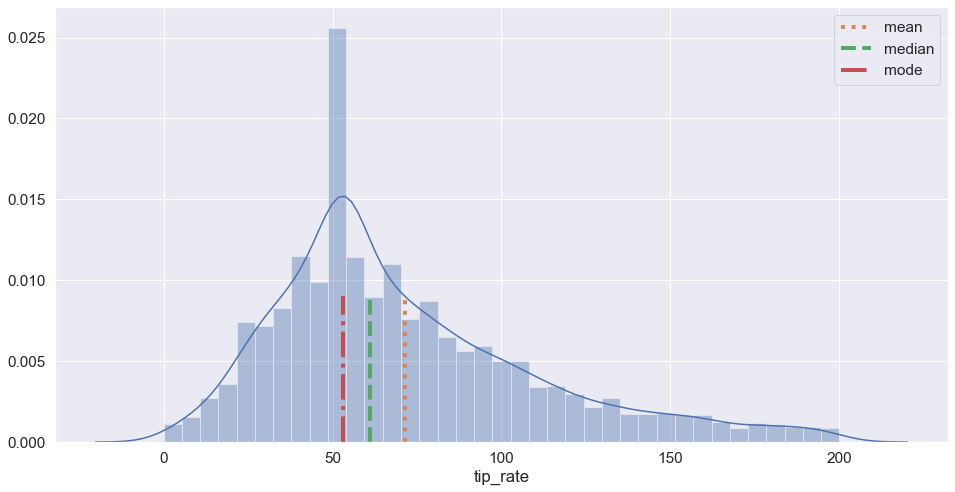

In [24]:
plt.figure(figsize = (16, 8))

sns.distplot(tip_rate_df['tip_rate'])

y = np.linspace(0, 0.009, 100)
plt.plot([mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

# plt.title('')
plt.legend()
plt.show()

In [25]:
#1/0

In [26]:
#используем ранее полученную моду и высчитаем годовой доход
def Annual_Income(df, target = None):
    
    cols = columns.copy()
    
    if target != None:  cols += target
    
    df2 = df.loc[df['Annual Income'].isna()
                ].assign(Annual_Income=df['Monthly Debt']*12*(100-mode)/mode
                        ).round(0)


    df = df.merge(df2, on='ID', how='left',suffixes=('', '_'))[cols+['Annual_Income']+['ID']]
    df['Annual Income'] = df['Annual_Income'].combine_first(df['Annual Income'])
    df = df[cols+['ID']]
    return df
    
train_df = Annual_Income(train_df, [target_name])
test_df = Annual_Income(test_df)

In [27]:
#1/0
df_corr['Bankruptcies']

Annual Income                  -0.066877
Tax Liens                       0.057360
Number of Open Accounts        -0.019130
Years of Credit History         0.085699
Maximum Open Credit            -0.011650
Number of Credit Problems       0.730751
Months since last delinquent    0.162710
Bankruptcies                    1.000000
Current Loan Amount            -0.005987
Current Credit Balance         -0.142849
Monthly Debt                   -0.079579
Credit Score                   -0.027488
Credit Default                  0.001648
ID                              0.003183
Name: Bankruptcies, dtype: float64

In [28]:
def learn_Bankruptcies(df, target = None):
    tmp_features = [ 'Years of Credit History','Number of Open Accounts', 'Maximum Open Credit',
                        'Monthly Debt', 'Number of Credit Problems'
                   ]
    # tmp_features = ['Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit',
    #                     'Monthly Debt', 'Number of Credit Problems', 'Months since last delinquent','Current Credit Balance'
    #                ]
    # Предикт лучше но итоговые значения хуже
    tmp_df = df.loc[df['Bankruptcies'].notna(), tmp_features] 


    tmp_target = df.loc[df['Bankruptcies'].notna(), 'Bankruptcies']

    X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(tmp_df, tmp_target, test_size=0.25,
                                                                        shuffle=True, random_state=17)
    model = RandomForestRegressor(n_jobs=2,
                                      n_estimators=100,
                                      min_samples_split=25,
                                      max_features=2,
                                      random_state=17)
    model.fit(X_train_tmp, y_train_tmp)
    predict_tpm = model.predict(X_test_tmp)

    annual_income_mean = df.loc[train_df['Bankruptcies'].notna(), 'Bankruptcies'].shape

    print('r2 предикта:', r2(y_test_tmp, predict_tpm))
    print('r2 mean значения:', r2(y_test_tmp, [annual_income_mean for val in range(X_test_tmp.shape[0])]))
    
    
    model = RandomForestRegressor(n_jobs=2,
                                  n_estimators=100,
                                  min_samples_split=25,
                                  max_features=2,
                                  random_state=17)
    model.fit(tmp_df, tmp_target)

    df['Bankruptcies_pred'] = model.predict(df.loc[:, tmp_features]).round()
    df['dif'] = df['Bankruptcies_pred'] / df['Bankruptcies']
    
    df['Bankruptcies'] = df['Bankruptcies_pred'].combine_first(df['Bankruptcies'])
    cols = columns.copy()
    if target != None: cols += [target_name]
    df = df[cols+['ID']]
    
    return df
train_df = learn_Bankruptcies(train_df,target_name)
test_df = learn_Bankruptcies(test_df)

r2 предикта: 0.7142289797570005
r2 mean значения: -505473164.9337568
r2 предикта: 0.6540200302757688
r2 mean значения: -64401661.451195054


In [29]:
# Проверил : у банкротов и не банкров мода одна в разных группах и решил всех причесать под "моду"
def all_to_mode(df):
    df.loc[(df['Months since last delinquent'].isna()), 'Months since last delinquent'
            ] = df.loc[(df['Months since last delinquent'].notna())
                            ]['Bankruptcies'].mode()[0]
    
    df.loc[(df['Credit Score'].notna())]['Credit Score'].mode()
    
    df.loc[(df['Credit Score'].isna()), 'Credit Score'
            ] = df.loc[(df['Credit Score'].notna())]['Credit Score'].mode()[0]
    #Гипотиза : 100 млн долга быть не может. Предположим,  что кредит выдан на 1 год
    #Можно в принципи подумать и тип домовладения включить влияющим фактором))))
    IDs = df.loc[(df['Current Loan Amount'] == 99999999.0)]['ID']

    df.loc[df['ID'].isin(IDs), 'Current Loan Amount'
                ] = df.loc[df['ID'].isin(IDs), 'Monthly Debt'
                                ].map(lambda x: x * 12 )
    return df
    
train_df = all_to_mode(train_df)
test_df = all_to_mode(test_df)

In [30]:
#Ошибочно оттолкнулся от таргета
#Гипотиза : для неучтенных банкротов при кредитном дефолте ставим 1 если нет дефолта то ноль
# train_df.loc[(train_df['Bankruptcies'].isna()) & (train_df['Credit Default']==1), ['Bankruptcies']] = 1
# train_df.loc[(train_df['Bankruptcies'].isna()) & (train_df['Credit Default']==0), ['Bankruptcies']] = 0

In [31]:
# Ошибочно
#Гипотиза : не можт быть не заполненным поле месяцы непросрочки
# Для Банкротов и дефолтов ставим среднее по полю Months since last delinquent 
# Для остальных ноль месяцев
# train_df.loc[(train_df['Months since last delinquent'].isna()
#              ) & ((train_df['Bankruptcies']>0)|(train_df['Credit Default']==1)
#                  )
#             , ['Months since last delinquent']] = round(train_df.loc[train_df['Months since last delinquent'
#                                                                              ].notna()
#                                                                     ]['Months since last delinquent'].mean())

# train_df.loc[(train_df['Months since last delinquent'].isna()
#              ) & ((train_df['Bankruptcies']==0)&(train_df['Credit Default']==0)
#                  )
#             , ['Months since last delinquent']] = 0

In [32]:
len(train_df) - train_df.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Home Ownership_id               0
Home Ownership_id               0
Home Ownership_id               0
Home Ownership_id               0
Purpose_id                      0
Purpose_id                      0
Purpose_id                      0
Purpose_id                      0
Term_id                         0
Term_id                         0
Term_id                         0
Term_id                         0
Home Ownership_id               0
Home Ownership

### Нормализация признаков

In [33]:
# Отключил нормализацию, так как качество лучше
# scaler = StandardScaler()

# df_norm = train_df.copy()
# df_norm[feature_names] = scaler.fit_transform(df_norm[feature_names])

# train_df = df_norm.copy()

#Здесь строил кореляцию в разбивке по группам категориальных признаков. Не помогло((
col = 'Bankruptcies'
for k, v in enumerate(train_df[col].unique()):
    df_corr = train_df.loc[(train_df['Credit Score'].notna())&(train_df[col]==v)][columns].corr()
    plt.figure(figsize = (25,25))

    sns.set(font_scale=1.4)
    sns.heatmap(df_corr, annot=True, linewidths=.5, cmap='GnBu')

    plt.title(f'Correlation matrix for {v}')
    plt.show()

In [34]:
train_df['Bankruptcies'].value_counts()

0.0    6508
1.0     988
2.0       4
Name: Bankruptcies, dtype: int64

In [35]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=1)

# result_ = pca.fit_transform(train_df)

# print(result_)

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [36]:
X = train_df[feature_names]
y = train_df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [37]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [38]:
X_train = df_balanced.drop(columns=target_name)
y_train = df_balanced[target_name]

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

**Логистическая регрессия**

In [39]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.75      0.71      3771
           1       0.63      0.54      0.58      2958

    accuracy                           0.66      6729
   macro avg       0.65      0.64      0.64      6729
weighted avg       0.65      0.66      0.65      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1616
           1       0.46      0.54      0.50       634

    accuracy                           0.69      2250
   macro avg       0.63      0.65      0.64      2250
weighted avg       0.71      0.69      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1215  401
1                292  342


**k ближайших соседей**

In [40]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.82      0.78      3771
           1       0.74      0.65      0.69      2958

    accuracy                           0.74      6729
   macro avg       0.74      0.74      0.74      6729
weighted avg       0.74      0.74      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.75      0.70      0.72      1616
           1       0.34      0.39      0.36       634

    accuracy                           0.61      2250
   macro avg       0.54      0.55      0.54      2250
weighted avg       0.63      0.61      0.62      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1125  491
1                384  250


### Бустинговые алгоритмы

**XGBoost**

In [41]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3771
           1       0.98      0.97      0.98      2958

    accuracy                           0.98      6729
   macro avg       0.98      0.98      0.98      6729
weighted avg       0.98      0.98      0.98      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      1616
           1       0.51      0.41      0.45       634

    accuracy                           0.72      2250
   macro avg       0.65      0.63      0.63      2250
weighted avg       0.71      0.72      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1373  243
1                377  257


**CatBoost**

In [42]:
final_model = catb.CatBoostClassifier(n_estimators=2500, max_depth=3,class_weights=[1, 1.5],
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      3771
           1       0.77      0.87      0.82      2958

    accuracy                           0.83      6729
   macro avg       0.83      0.83      0.83      6729
weighted avg       0.84      0.83      0.83      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1616
           1       0.44      0.59      0.51       634

    accuracy                           0.68      2250
   macro avg       0.63      0.65      0.63      2250
weighted avg       0.71      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1145  471
1                259  375


In [43]:
final_model = catb.CatBoostClassifier(n_estimators=2500, max_depth=3,
                                      class_weights=[1, 1.5],
                                      silent=True, random_state=21)

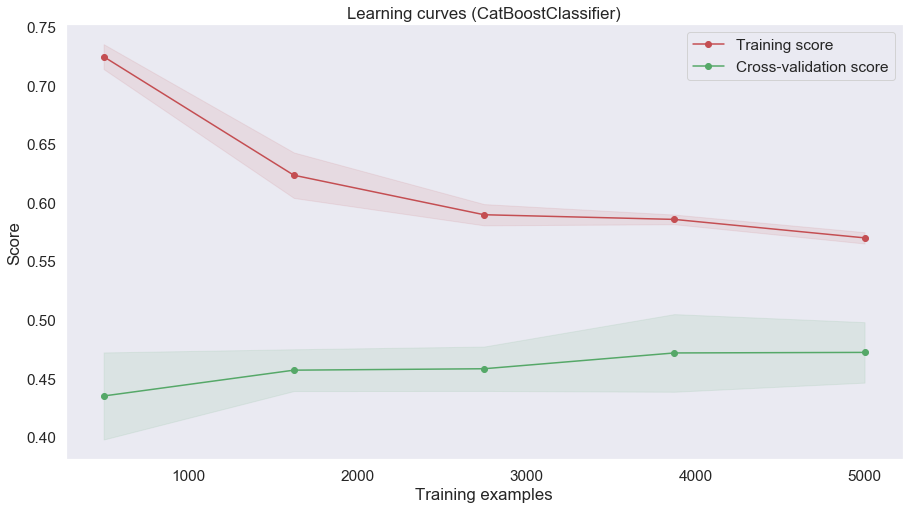

CPU times: user 454 ms, sys: 87.8 ms, total: 542 ms
Wall time: 1min 30s


In [44]:
%%time
show_learning_curve_plot(final_model, X, y)

### Вывод:

CatBoost показал лучшие результаты: 
* берем его
* обучаем модель на полной выборке

In [45]:
final_model = catb.CatBoostClassifier(n_estimators=2500, max_depth=3,class_weights=[1, 1.5],
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(train_df[feature_names], train_df[target_name])

y_train_pred = final_model.predict(train_df[feature_names])
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(train_df[target_name], y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.95      0.90      5387
           1       0.82      0.55      0.66      2113

    accuracy                           0.84      7500
   macro avg       0.83      0.75      0.78      7500
weighted avg       0.84      0.84      0.83      7500

TEST

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      1616
           1       0.83      0.53      0.65       634

    accuracy                           0.84      2250
   macro avg       0.84      0.75      0.77      2250
weighted avg       0.84      0.84      0.83      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1548   68
1                296  338


### Сохраняем финальную модель

In [46]:
with open('final_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

### Финальное предсказание

In [47]:


y_test_pred = final_model.predict(test_df[feature_names])

test_df[target_name] = y_test_pred


In [48]:
test_df[feature_names + [target_name]].head(10)

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,72501.0,4.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,162470.0,105906.0,6813.0,746.0,0
1,231838.0,1.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,78298.0,46037.0,2318.0,699.0,1
2,1152540.0,3.0,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,200178.0,146490.0,18729.0,7260.0,1
3,1220313.0,10.0,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,217382.0,213199.0,27559.0,739.0,0
4,2340952.0,6.0,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,777634.0,425391.0,42605.0,706.0,0
5,922583.0,5.0,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,94028.0,135508.0,11148.0,679.0,0
6,1233309.0,3.0,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,454388.0,292904.0,8181.0,685.0,0
7,1215867.0,3.0,0.0,13.0,12.2,195888.0,0.0,19.0,0.0,407726.0,120099.0,7599.0,701.0,0
8,107607.0,5.0,0.0,8.0,9.1,370524.0,0.0,0.0,0.0,131956.0,237747.0,10112.0,746.0,0
9,2140445.0,10.0,1.0,15.0,16.7,867680.0,1.0,9.0,1.0,391336.0,294500.0,18372.0,745.0,0


### Финальное предсказание запишим в файл CSV

In [49]:
test_df[feature_names + [target_name]].to_csv('RozhnovVA_predictions.csv') 